In [2]:
import pyspark
print(pyspark.__version__)

4.0.1


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()

In [10]:
# Import deps
import ipywidgets as widgets
from IPython.display import display
import os

# Upload widget - allow multiple files of any type to simulate folder upload
train_uploader = widgets.FileUpload(accept='', multiple=True)

# Text input for folder name to save into
folder_input = widgets.Text(
    value='uploaded_data',
    placeholder='Enter folder name',
    description='Save to:',
    style={'description_width': 'initial'}
)

# Create an output widget to display status
output = widgets.Output()

def save_files(change):
    """Callback function to save uploaded files into the specified folder"""
    with output:
        output.clear_output()
        if train_uploader.value:
            folder = folder_input.value.strip() or 'uploaded_data'
            os.makedirs(folder, exist_ok=True)
            for filename, file_info in train_uploader.value.items():
                filepath = os.path.join(folder, filename)
                with open(filepath, "wb") as f:
                    f.write(file_info['content'])
                print(f"Saved: {filepath}")
            print(f"\nAll {len(train_uploader.value)} file(s) saved to '{folder}/'")
        else:
            print("No files uploaded yet. Please upload files first.")

# Button to trigger save
save_button = widgets.Button(
    description='Save Uploaded Files',
    button_style='success',
    tooltip='Click after uploading files to save them',
    icon='save'
)

save_button.on_click(lambda _: save_files(None))

# Observe the upload widget for changes
train_uploader.observe(save_files, names='value')

# Display widgets
print("Select all files from your folder (Ctrl+A in the file dialog).")
print("They will be saved into the specified folder.\n")
display(folder_input)
display(train_uploader)
display(save_button)
display(output)


Select all files from your folder (Ctrl+A in the file dialog).
They will be saved into the specified folder.



Text(value='uploaded_data', description='Save to:', placeholder='Enter folder name', style=DescriptionStyle(de…

FileUpload(value={}, description='Upload', multiple=True)

Button(button_style='success', description='Save Uploaded Files', icon='save', style=ButtonStyle(), tooltip='C…

Output()

In [12]:
import os

folder = folder_input.value.strip() or 'uploaded_data'
if os.path.exists(folder):
    files = os.listdir(folder)
    print(f"Files in '{folder}/' ({len(files)} total):")
    for f in files:
        filepath = os.path.join(folder, f)
        size = os.path.getsize(filepath)
        print(f"  {f} ({size} bytes)")
else:
    print(f"Folder '{folder}/' does not exist yet.")

Files in 'uploaded_data/' (36 total):
  doge_data_2024_10.csv (10793 bytes)
  doge_data_2023_10.csv (10718 bytes)
  doge_data_2024_03.csv (10935 bytes)
  doge_data_2024_09.csv (10344 bytes)
  doge_data_2025_12.csv (10622 bytes)
  doge_data_2024_02.csv (10045 bytes)
  doge_data_2024_04.csv (10536 bytes)
  doge_data_2024_12.csv (10857 bytes)
  doge_data_2023_09.csv (10351 bytes)
  doge_data_2025_10.csv (10699 bytes)
  doge_data_2023_12.csv (10792 bytes)
  doge_data_2025_11.csv (10344 bytes)
  doge_data_2023_11.csv (10473 bytes)
  doge_data_2025_02.csv (9749 bytes)
  doge_data_2023_02.csv (9736 bytes)
  doge_data_2025_09.csv (10375 bytes)
  doge_data_2025_05.csv (10769 bytes)
  doge_data_2025_03.csv (10757 bytes)
  doge_data_2025_01.csv (10802 bytes)
  doge_data_2024_07.csv (10755 bytes)
  doge_data_2025_07.csv (10748 bytes)
  doge_data_2023_03.csv (10806 bytes)
  doge_data_2024_08.csv (10717 bytes)
  doge_data_2024_05.csv (10806 bytes)
  doge_data_2024_06.csv (10390 bytes)
  doge_data_20

In [13]:
# Read CSV files from the uploaded folder using PySpark
folder = folder_input.value.strip() or 'uploaded_data'

# Read all CSV files from the folder
df = spark.read.option("header", "true").option("inferSchema", "true").csv(os.path.join(folder, "*.csv"))

print(f"Schema of the loaded data:")
df.printSchema()
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

# Define output path for parquet
parquet_output = os.path.join(folder, "parquet_output")

# Write the DataFrame as Parquet format
df.write.mode("overwrite").parquet(parquet_output)

print(f"\nData successfully converted to Parquet format at '{parquet_output}/'")

# Verify by reading back the parquet files
df_parquet = spark.read.parquet(parquet_output)
print(f"Parquet verification - Rows: {df_parquet.count()}, Columns: {len(df_parquet.columns)}")
df_parquet.show(5)

Schema of the loaded data:
root
 |-- datetime: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)

Number of rows: 6576
Number of columns: 6

Data successfully converted to Parquet format at 'uploaded_data/parquet_output/'
Parquet verification - Rows: 6576, Columns: 6
+-------------------+------+------+------+------+-----------+
|           datetime|  open|  high|   low| close|     volume|
+-------------------+------+------+------+------+-----------+
|2024-03-01 01:00:00|0.1175|0.1221|0.1168|0.1198|2.6370124E7|
|2024-03-01 05:00:00|0.1197|0.1224|0.1179|0.1186| 2.225858E7|
|2024-03-01 09:00:00|0.1185|0.1238|0.1178|0.1219|1.9515796E7|
|2024-03-01 13:00:00| 0.122|0.1305|0.1208|0.1244|3.1958144E7|
|2024-03-01 17:00:00|0.1239|0.1397|0.1239|0.1357|1.1720717E8|
+-------------------+------+------+------+------+-----------+
only showing t

In [19]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# --- SMA 200 ---
window_sma200 = Window.orderBy("datetime").rowsBetween(-199, 0)
df_indicators = df_parquet.withColumn("SMA_200", F.avg("Close").over(window_sma200))

# --- EMA 50 ---
# Approximate EMA using recursive formula: EMA_t = alpha * Close_t + (1 - alpha) * EMA_{t-1}
# We use a collect_list + UDF-free approach via exponential weighted sum over window

ema_span_50 = 50
alpha_50 = 2.0 / (ema_span_50 + 1)

window_ema50 = Window.orderBy("datetime").rowsBetween(-ema_span_50 * 4, 0)  # use ~4x span for convergence
# Assign row numbers for weight calculation
df_indicators = df_indicators.withColumn("_row_num", F.row_number().over(Window.orderBy("datetime")))

# Collect close values in window, then compute weighted average with exponential decay
df_indicators = df_indicators.withColumn(
    "_close_list", F.collect_list("Close").over(window_ema50)
)

# EMA via explode + exponential weights
@F.udf("double")
def compute_ema(close_list, alpha):
    if not close_list:
        return None
    ema = float(close_list[0])
    for c in close_list[1:]:
        ema = alpha * float(c) + (1.0 - alpha) * ema
    return ema

df_indicators = df_indicators.withColumn("EMA_50", compute_ema(F.col("_close_list"), F.lit(alpha_50)))

# --- RSI 14 ---
rsi_period = 14
alpha_rsi = 1.0 / rsi_period
window_rsi = Window.orderBy("datetime").rowsBetween(-rsi_period * 10, 0)

df_indicators = df_indicators.withColumn("_prev_close", F.lag("Close", 1).over(Window.orderBy("datetime")))
df_indicators = df_indicators.withColumn("_delta", F.col("Close") - F.col("_prev_close"))
df_indicators = df_indicators.withColumn("_gain", F.when(F.col("_delta") > 0, F.col("_delta")).otherwise(0.0))
df_indicators = df_indicators.withColumn("_loss", F.when(F.col("_delta") < 0, -F.col("_delta")).otherwise(0.0))

df_indicators = df_indicators.withColumn("_gain_list", F.collect_list("_gain").over(window_rsi))
df_indicators = df_indicators.withColumn("_loss_list", F.collect_list("_loss").over(window_rsi))

@F.udf("double")
def compute_rsi(gain_list, loss_list, alpha):
    if not gain_list or len(gain_list) < 14:
        return None
    avg_gain = sum(gain_list[:14]) / 14.0
    avg_loss = sum(loss_list[:14]) / 14.0
    for i in range(14, len(gain_list)):
        avg_gain = alpha * float(gain_list[i]) + (1.0 - alpha) * avg_gain
        avg_loss = alpha * float(loss_list[i]) + (1.0 - alpha) * avg_loss
    if avg_loss == 0:
        return 100.0
    rs = avg_gain / avg_loss
    return 100.0 - (100.0 / (1.0 + rs))

df_indicators = df_indicators.withColumn("RSI_14", compute_rsi(F.col("_gain_list"), F.col("_loss_list"), F.lit(alpha_rsi)))

# --- MACD ---
alpha_12 = 2.0 / 13.0
alpha_26 = 2.0 / 27.0
alpha_9 = 2.0 / 10.0

window_macd = Window.orderBy("datetime").rowsBetween(-200, 0)
df_indicators = df_indicators.withColumn("_close_list_macd", F.collect_list("Close").over(window_macd))

@F.udf("struct<MACD:double,MACD_Signal:double,MACD_Histogram:double>")
def compute_macd(close_list, a12, a26, a9):
    if not close_list or len(close_list) < 26:
        return None
    ema12 = float(close_list[0])
    ema26 = float(close_list[0])
    macd_vals = []
    for c in close_list:
        c = float(c)
        ema12 = a12 * c + (1 - a12) * ema12
        ema26 = a26 * c + (1 - a26) * ema26
        macd_vals.append(ema12 - ema26)
    signal = macd_vals[0]
    for m in macd_vals:
        signal = a9 * m + (1 - a9) * signal
    macd = macd_vals[-1]
    return (macd, signal, macd - signal)

df_indicators = df_indicators.withColumn(
    "_macd_struct", compute_macd(F.col("_close_list_macd"), F.lit(alpha_12), F.lit(alpha_26), F.lit(alpha_9))
)
df_indicators = df_indicators.withColumn("MACD", F.col("_macd_struct.MACD"))
df_indicators = df_indicators.withColumn("MACD_Signal", F.col("_macd_struct.MACD_Signal"))
df_indicators = df_indicators.withColumn("MACD_Histogram", F.col("_macd_struct.MACD_Histogram"))

# Drop temporary columns
df_final = df_indicators.drop(
    "_row_num", "_close_list", "_prev_close", "_delta", "_gain", "_loss",
    "_gain_list", "_loss_list", "_close_list_macd", "_macd_struct"
).orderBy("datetime")

print("Technical Indicators Calculated: SMA_200, EMA_50, RSI_14, MACD, MACD_Signal, MACD_Histogram")
df_final.select("datetime", "Close", "SMA_200", "EMA_50", "RSI_14", "MACD", "MACD_Signal", "MACD_Histogram").show(20, truncate=False)

Technical Indicators Calculated: SMA_200, EMA_50, RSI_14, MACD, MACD_Signal, MACD_Histogram
+-------------------+------+-------------------+-------------------+------------------+----+-----------+--------------+
|datetime           |Close |SMA_200            |EMA_50             |RSI_14            |MACD|MACD_Signal|MACD_Histogram|
+-------------------+------+-------------------+-------------------+------------------+----+-----------+--------------+
|2023-01-01 01:00:00|0.0697|0.0697             |0.0697             |NULL              |NULL|NULL       |NULL          |
|2023-01-01 05:00:00|0.0694|0.06955            |0.06968823529411763|NULL              |NULL|NULL       |NULL          |
|2023-01-01 09:00:00|0.0696|0.06956666666666667|0.06968477508650518|NULL              |NULL|NULL       |NULL          |
|2023-01-01 13:00:00|0.0699|0.06965            |0.06969321527919126|NULL              |NULL|NULL       |NULL          |
|2023-01-01 17:00:00|0.0702|0.06976            |0.0697130891898112 |

/tmp/ipython-input-2196721745.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-2196721745.py:185: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.savefig("technical_analysis_dashboard.png", dpi=150, bbox_inches="tight", facecolor="white")
/tmp/ipython-input-2196721745.py:185: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Liberation Sans.
  plt.savefig("technical_analysis_dashboard.png", dpi=150, bbox_inches="tight", facecolor="white")
/tmp/ipython-input-2196721745.py:185: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Liberation Sans.
  plt.savefig("technical_analysis_dashboard.png", dpi=150, bbox_inches="tight", facecolor="white")
/tmp/ipython-input-2196721745.py:185: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.savefig("technical_analysis_dashboa

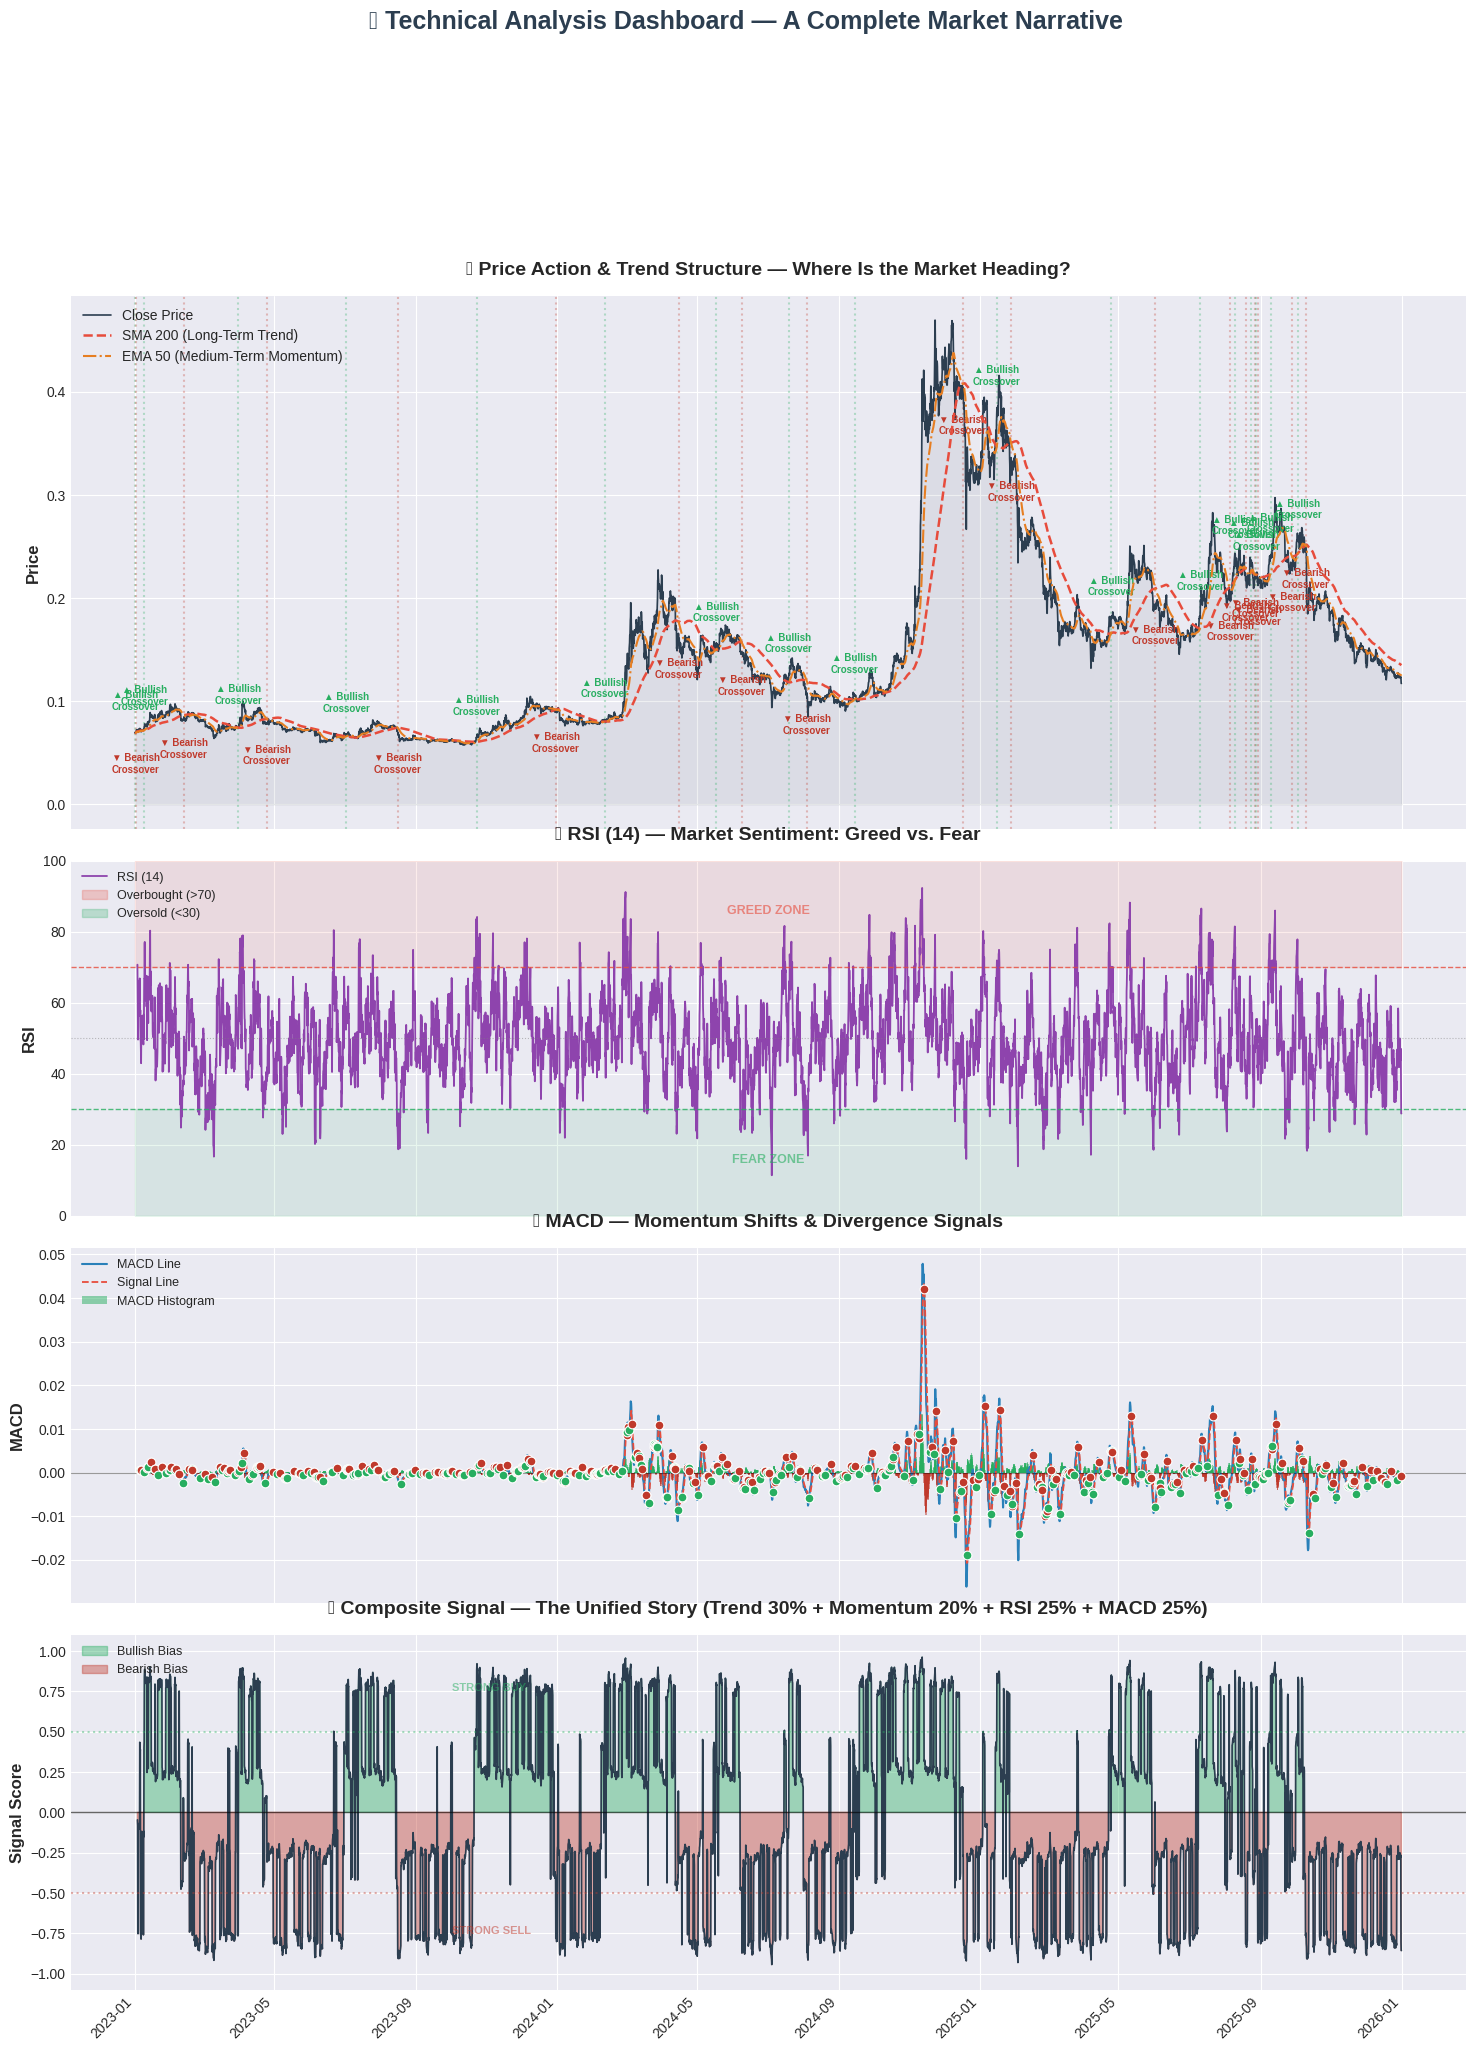


✅ Dashboard saved as 'technical_analysis_dashboard.png'
📅 Period: 2023-01-01 → 2025-12-31
📊 Data points: 6,576


In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert to Pandas for plotting
pdf = df_final.select(
    "datetime", "Close", "SMA_200", "EMA_50", "RSI_14",
    "MACD", "MACD_Signal", "MACD_Histogram"
).orderBy("datetime").toPandas()

pdf["datetime"] = pd.to_datetime(pdf["datetime"])
pdf = pdf.sort_values("datetime").reset_index(drop=True)

# ── Color palette & style ──
plt.style.use("seaborn-v0_8-darkgrid")
colors = {
    "close": "#2c3e50", "sma200": "#e74c3c", "ema50": "#e67e22",
    "rsi": "#8e44ad", "macd": "#2980b9", "signal": "#e74c3c",
    "hist_pos": "#27ae60", "hist_neg": "#c0392b",
    "overbought": "#e74c3c", "oversold": "#27ae60"
}

fig, axes = plt.subplots(4, 1, figsize=(18, 22), sharex=True,
                         gridspec_kw={"height_ratios": [3, 2, 2, 2], "hspace": 0.08})

# ═══════════════════════════════════════════════════════════════
# PANEL 1: Price + SMA 200 + EMA 50 — The Trend Narrative
# ═══════════════════════════════════════════════════════════════
ax1 = axes[0]
ax1.fill_between(pdf["datetime"], pdf["Close"], alpha=0.08, color=colors["close"])
ax1.plot(pdf["datetime"], pdf["Close"], color=colors["close"], linewidth=1.2, label="Close Price", zorder=3)
ax1.plot(pdf["datetime"], pdf["SMA_200"], color=colors["sma200"], linewidth=1.8, linestyle="--",
         label="SMA 200 (Long-Term Trend)", zorder=4)
ax1.plot(pdf["datetime"], pdf["EMA_50"], color=colors["ema50"], linewidth=1.5, linestyle="-.",
         label="EMA 50 (Medium-Term Momentum)", zorder=4)

# Highlight golden/death crosses (EMA50 crossing SMA200)
ema_above = pdf["EMA_50"] > pdf["SMA_200"]
crosses = ema_above.ne(ema_above.shift()).fillna(False)
for idx in pdf[crosses].index:
    if idx == 0:
        continue
    if ema_above.iloc[idx]:  # Golden cross
        ax1.axvline(pdf["datetime"].iloc[idx], color=colors["hist_pos"], alpha=0.3, linestyle=":", linewidth=1.5)
        ax1.annotate("▲ Bullish\nCrossover", xy=(pdf["datetime"].iloc[idx], pdf["Close"].iloc[idx]),
                     fontsize=7, color=colors["hist_pos"], fontweight="bold",
                     ha="center", va="bottom", xytext=(0, 15), textcoords="offset points")
    else:  # Death cross
        ax1.axvline(pdf["datetime"].iloc[idx], color=colors["hist_neg"], alpha=0.3, linestyle=":", linewidth=1.5)
        ax1.annotate("▼ Bearish\nCrossover", xy=(pdf["datetime"].iloc[idx], pdf["Close"].iloc[idx]),
                     fontsize=7, color=colors["hist_neg"], fontweight="bold",
                     ha="center", va="top", xytext=(0, -15), textcoords="offset points")

ax1.set_ylabel("Price", fontsize=12, fontweight="bold")
ax1.set_title("📈 Price Action & Trend Structure — Where Is the Market Heading?",
              fontsize=14, fontweight="bold", pad=15)
ax1.legend(loc="upper left", fontsize=10, framealpha=0.9)

# ═══════════════════════════════════════════════════════════════
# PANEL 2: RSI 14 — The Sentiment Gauge
# ═══════════════════════════════════════════════════════════════
ax2 = axes[1]
ax2.plot(pdf["datetime"], pdf["RSI_14"], color=colors["rsi"], linewidth=1.3, label="RSI (14)")

# Overbought / Oversold zones
ax2.axhline(70, color=colors["overbought"], linestyle="--", linewidth=1, alpha=0.8)
ax2.axhline(30, color=colors["oversold"], linestyle="--", linewidth=1, alpha=0.8)
ax2.axhline(50, color="gray", linestyle=":", linewidth=0.8, alpha=0.5)

ax2.fill_between(pdf["datetime"], 70, 100, alpha=0.10, color=colors["overbought"])
ax2.fill_between(pdf["datetime"], 0, 30, alpha=0.10, color=colors["oversold"])

# Highlight extreme RSI moments
rsi_vals = pdf["RSI_14"].dropna()
if len(rsi_vals) > 0:
    overbought_mask = pdf["RSI_14"] > 70
    oversold_mask = pdf["RSI_14"] < 30
    ax2.fill_between(pdf["datetime"], pdf["RSI_14"], 70,
                     where=overbought_mask, alpha=0.25, color=colors["overbought"],
                     interpolate=True, label="Overbought (>70)")
    ax2.fill_between(pdf["datetime"], pdf["RSI_14"], 30,
                     where=oversold_mask, alpha=0.25, color=colors["oversold"],
                     interpolate=True, label="Oversold (<30)")

ax2.annotate("GREED ZONE", xy=(pdf["datetime"].iloc[len(pdf)//2], 85),
             fontsize=9, color=colors["overbought"], fontweight="bold", alpha=0.6, ha="center")
ax2.annotate("FEAR ZONE", xy=(pdf["datetime"].iloc[len(pdf)//2], 15),
             fontsize=9, color=colors["oversold"], fontweight="bold", alpha=0.6, ha="center")

ax2.set_ylim(0, 100)
ax2.set_ylabel("RSI", fontsize=12, fontweight="bold")
ax2.set_title("🧠 RSI (14) — Market Sentiment: Greed vs. Fear",
              fontsize=14, fontweight="bold", pad=15)
ax2.legend(loc="upper left", fontsize=9, framealpha=0.9)

# ═══════════════════════════════════════════════════════════════
# PANEL 3: MACD — The Momentum Engine
# ═══════════════════════════════════════════════════════════════
ax3 = axes[2]

# Histogram with gradient coloring
hist_colors = [colors["hist_pos"] if v >= 0 else colors["hist_neg"]
               for v in pdf["MACD_Histogram"].fillna(0)]
ax3.bar(pdf["datetime"], pdf["MACD_Histogram"].fillna(0), color=hist_colors,
        alpha=0.5, width=1.5, label="MACD Histogram")

ax3.plot(pdf["datetime"], pdf["MACD"], color=colors["macd"], linewidth=1.5, label="MACD Line")
ax3.plot(pdf["datetime"], pdf["MACD_Signal"], color=colors["signal"], linewidth=1.3,
         linestyle="--", label="Signal Line")
ax3.axhline(0, color="black", linewidth=0.8, alpha=0.4)

# Annotate MACD crossovers
macd_above = pdf["MACD"] > pdf["MACD_Signal"]
macd_crosses = macd_above.ne(macd_above.shift()).fillna(False)
cross_points = pdf[macd_crosses & pdf["MACD"].notna()]
for _, row in cross_points.iterrows():
    marker_color = colors["hist_pos"] if row["MACD"] > row["MACD_Signal"] else colors["hist_neg"]
    ax3.scatter(row["datetime"], row["MACD"], color=marker_color, s=40, zorder=5,
                edgecolors="white", linewidth=0.8)

ax3.set_ylabel("MACD", fontsize=12, fontweight="bold")
ax3.set_title("⚡ MACD — Momentum Shifts & Divergence Signals",
              fontsize=14, fontweight="bold", pad=15)
ax3.legend(loc="upper left", fontsize=9, framealpha=0.9)

# ═══════════════════════════════════════════════════════════════
# PANEL 4: Composite Score — The Decision Dashboard
# ═══════════════════════════════════════════════════════════════
ax4 = axes[3]

# Normalize each indicator to a -1 to 1 signal score
pdf_score = pdf.copy()
# Trend signal: +1 if price > SMA200, -1 otherwise
pdf_score["trend_score"] = np.where(pdf_score["Close"] > pdf_score["SMA_200"], 1, -1)
# Momentum signal: +1 if EMA50 > SMA200, -1 otherwise
pdf_score["momentum_score"] = np.where(pdf_score["EMA_50"] > pdf_score["SMA_200"], 1, -1)
# RSI signal: normalize from 0-100 to -1 to 1
pdf_score["rsi_score"] = ((pdf_score["RSI_14"] - 50) / 50).clip(-1, 1)
# MACD signal: +1 if MACD > Signal, -1 otherwise
pdf_score["macd_score"] = np.where(pdf_score["MACD"] > pdf_score["MACD_Signal"], 1, -1)

# Composite
pdf_score["composite"] = (
    pdf_score["trend_score"] * 0.3 +
    pdf_score["momentum_score"] * 0.2 +
    pdf_score["rsi_score"] * 0.25 +
    pdf_score["macd_score"] * 0.25
)

composite_colors = ["#27ae60" if v >= 0 else "#c0392b" for v in pdf_score["composite"].fillna(0)]
ax4.fill_between(pdf_score["datetime"], pdf_score["composite"], 0,
                 where=pdf_score["composite"] >= 0, alpha=0.4, color=colors["hist_pos"],
                 interpolate=True, label="Bullish Bias")
ax4.fill_between(pdf_score["datetime"], pdf_score["composite"], 0,
                 where=pdf_score["composite"] < 0, alpha=0.4, color=colors["hist_neg"],
                 interpolate=True, label="Bearish Bias")
ax4.plot(pdf_score["datetime"], pdf_score["composite"], color="#2c3e50", linewidth=1.2)
ax4.axhline(0, color="black", linewidth=1, alpha=0.6)
ax4.axhline(0.5, color=colors["hist_pos"], linestyle=":", alpha=0.4)
ax4.axhline(-0.5, color=colors["hist_neg"], linestyle=":", alpha=0.4)

ax4.annotate("STRONG BUY", xy=(pdf_score["datetime"].iloc[len(pdf)//4], 0.75),
             fontsize=8, color=colors["hist_pos"], fontweight="bold", alpha=0.5)
ax4.annotate("STRONG SELL", xy=(pdf_score["datetime"].iloc[len(pdf)//4], -0.75),
             fontsize=8, color=colors["hist_neg"], fontweight="bold", alpha=0.5)

ax4.set_ylim(-1.1, 1.1)
ax4.set_ylabel("Signal Score", fontsize=12, fontweight="bold")
ax4.set_title("🎯 Composite Signal — The Unified Story (Trend 30% + Momentum 20% + RSI 25% + MACD 25%)",
              fontsize=14, fontweight="bold", pad=15)
ax4.legend(loc="upper left", fontsize=9, framealpha=0.9)

# Format x-axis
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax4.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45, ha="right")

# Final polish
fig.suptitle("📊 Technical Analysis Dashboard — A Complete Market Narrative",
             fontsize=18, fontweight="bold", y=1.01, color="#2c3e50")

plt.tight_layout()
plt.savefig("technical_analysis_dashboard.png", dpi=150, bbox_inches="tight", facecolor="white")
plt.show()

print("\n✅ Dashboard saved as 'technical_analysis_dashboard.png'")
print(f"📅 Period: {pdf['datetime'].min().strftime('%Y-%m-%d')} → {pdf['datetime'].max().strftime('%Y-%m-%d')}")
print(f"📊 Data points: {len(pdf):,}")